In [1]:
import numpy as np
import pandas as pd
import os
import nltk
from nltk.corpus import *
from nltk.stem import PorterStemmer

In [2]:

nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
path = '/content/drive/MyDrive/ML_project/Dataset/'
df1 = pd.read_csv("E:/Assignments/0.1_web_dev/reduced_fake_job_postings.csv")
df1.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,17736,Administrative Assistant,"US, CA, Santa Ana",NIL,NIL,NIL,In addition to clerical and administrative du...,NIL,No requirements,0,0,0,Full-time,NIL,NIL,Accounting,Administrative,1
1,5779,SEO Specialist,"PL, MZ, Warszawa",Marketing,NIL,NIL,Positionly Inc. is a company that provides the...,1 year of experience in managing SEO campaigns...,"Attractive salary, depending on experienceFull...",0,1,1,Full-time,NIL,Unspecified,Internet,Marketing,0
2,9687,Sql BI Developer,"US, TX, Austin",NIL,NIL,NIL,"Designs, develops, and maintains SSRS re...",Minimum Requirements:Years Skills/E...,NIL,0,0,0,Contract,Mid-Senior level,NIL,NIL,NIL,0
3,6097,Account Manager South Africa,"ZA, , Johannesburg",Sales,NIL,Upstream’s mission is to revolutionise the way...,The Account Manager SA will help derive and im...,Knowledge/Skills/ExperienceProven sales and ac...,Salary and BenefitsIncludes attractive competi...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Telecommunications,Sales,0
4,350,Embedded Systems / Telematics Security Consultant,NIL,Professional Services,NIL,Cylance is a global cybersecurity products and...,SummaryImmediate requirement for an advanced t...,QualificationsBachelor degree in Information T...,NIL,0,1,0,NIL,NIL,NIL,NIL,NIL,0


In [22]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import pickle
# Load dataset
df = pd.read_csv("E:/Assignments/0.1_web_dev/reduced_fake_job_postings.csv")


In [23]:
print(df.columns)

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent'],
      dtype='object')


In [24]:
df.columns = df.columns.str.strip()

In [25]:

text_columns = ['company_profile', 'description', 'requirements', 'benefits']
df[text_columns] = df[text_columns].fillna('')


stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and apply stemming
    tokens = [ps.stem(word) for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(tokens)



In [26]:
# Apply the text preprocessing function to each column
for col in text_columns:
    df[col] = df[col].apply(preprocess_text)

In [27]:
text_columns = ['company_profile', 'description', 'requirements', 'benefits']

# Fill NaN values with an empty string and convert all columns to strings
df[text_columns] = df[text_columns].fillna('').astype(str)

# Combine the text columns into a single column
df['combined_text'] = df[text_columns].agg(' '.join, axis=1)

# Create the TF-IDF matrix
tfidf = TfidfVectorizer(max_features=10191)  # Adjust max_features as needed
X_tfidf = tfidf.fit_transform(df['combined_text'])

# Convert the TF-IDF matrix to a DataFrame
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())


In [28]:
# Select additional feature columns
additional_columns = ['telecommuting', 'has_company_logo', 'has_questions', 'required_experience', 'required_education', 'industry', 'function']
df_additional = df[additional_columns].fillna('')

# One-Hot Encode the categorical columns
categorical_columns = ['required_experience', 'required_education', 'industry', 'function']
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(df[['required_experience', 'required_education', 'industry', 'function']])
df_encoded = pd.DataFrame(encoder.fit_transform(df_additional[categorical_columns]), columns=encoder.get_feature_names_out(categorical_columns))

# Combine TF-IDF matrix with additional features (including encoded categorical features)
df_additional_numeric = df_additional[['telecommuting', 'has_company_logo', 'has_questions']].fillna(0).astype(float)
X = pd.concat([X_tfidf_df, df_additional_numeric.reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)


# Target column (assuming it's 'fraudulent' based on job classification)
y = df['fraudulent']


In [29]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a classification model (e.g., Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))




              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2521
           1       1.00      1.00      1.00      2479

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [30]:
os.makedirs('E:/Assignments/0.1_web_dev/model', exist_ok=True)
with open('E:/Assignments/0.1_web_dev/model/model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

with open('E:/Assignments/0.1_web_dev/model/encoder.pkl', 'wb') as encoder_file:
    pickle.dump(encoder, encoder_file)

# Also save TF-IDF Vectorizer if you’ll need it in the app
with open('E:/Assignments/0.1_web_dev/model/tfidf.pkl', 'wb') as tfidf_file:
    pickle.dump(tfidf, tfidf_file)

In [31]:
import pickle
import pandas as pd

# Load the saved model and vectorizer
with open('E:/Assignments/0.1_web_dev/model/model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('E:/Assignments/0.1_web_dev/model/tfidf.pkl', 'rb') as tfidf_file:
    tfidf_vectorizer = pickle.load(tfidf_file)

# Sample job posting for prediction
sample_data = {
    'title': 'Software Engineer',
    'company_profile': 'A tech startup',
    'description': 'Looking for a Python developer with AI experience.',
    'requirements': '3+ years experience with Python and machine learning',
    'benefits': 'Healthcare and stock options',
}

# Combine text fields similarly to training
sample_text = ' '.join([sample_data[field] for field in ['title', 'company_profile', 'description', 'requirements', 'benefits']])

# Transform text using the loaded vectorizer
sample_text_vectorized = tfidf_vectorizer.transform([sample_text])

# Create a DataFrame for the vectorized text
sample_text_df = pd.DataFrame(sample_text_vectorized.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Add any additional features (default values or manual inputs if needed)
additional_features = pd.DataFrame([[0, 1, 0]], columns=['telecommuting', 'has_company_logo', 'has_questions'])

# Create an empty DataFrame for encoded features with the correct columns
encoded_columns = [col for col in model.feature_names_in_ if col not in sample_text_df.columns and col not in additional_features.columns]
encoded_features = pd.DataFrame([[0] * len(encoded_columns)], columns=encoded_columns)

# Combine all features
sample_features = pd.concat([sample_text_df, additional_features, encoded_features], axis=1)

# Remove duplicate columns, if any
sample_features = sample_features.loc[:, ~sample_features.columns.duplicated()]

# Ensure columns match the model’s expected input
sample_features = sample_features.reindex(columns=model.feature_names_in_, fill_value=0)

# Predict using the loaded model
prediction = model.predict(sample_features)
result = 'Fraudulent' if prediction[0] == 1 else 'Legitimate'
print(f'The sample job posting is predicted as: {result}')


The sample job posting is predicted as: Legitimate


In [32]:
import pickle

# Load the saved model and vectorizer
with open('E:/Assignments/0.1_web_dev/model/model.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

with open('E:/Assignments/0.1_web_dev/model/tfidf.pkl', 'rb') as tfidf_file:
    tfidf_vectorizer = pickle.load(tfidf_file)

# Check feature counts
print(f"Model expects {model.n_features_in_} features.")
print(f"Vectorizer provides {tfidf_vectorizer.transform(['']).shape[1]} features.")

# If the feature counts don't match, retrain or save compatible versions


Model expects 10381 features.
Vectorizer provides 10191 features.


In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


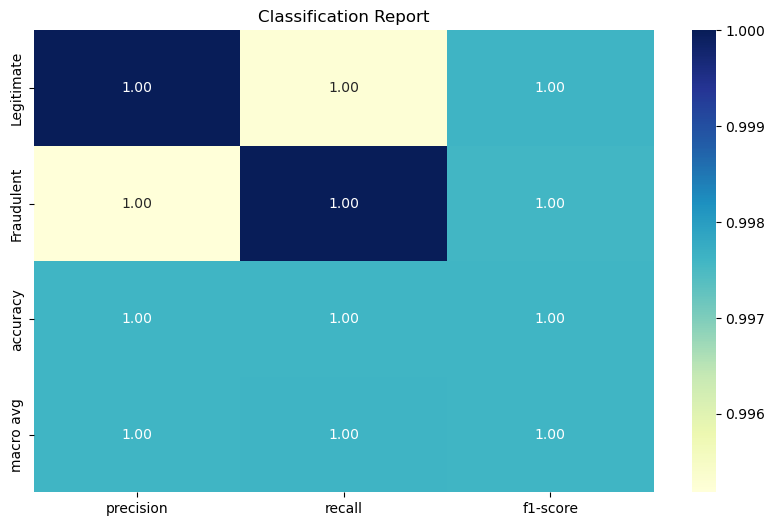

In [33]:
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
# Get classification report as a dictionary
report = classification_report(y_test, y_pred, target_names=['Legitimate', 'Fraudulent'], output_dict=True)

# Convert to DataFrame for easier plotting
report_df = pd.DataFrame(report).transpose()

# Plot with Seaborn
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Classification Report')
plt.show()


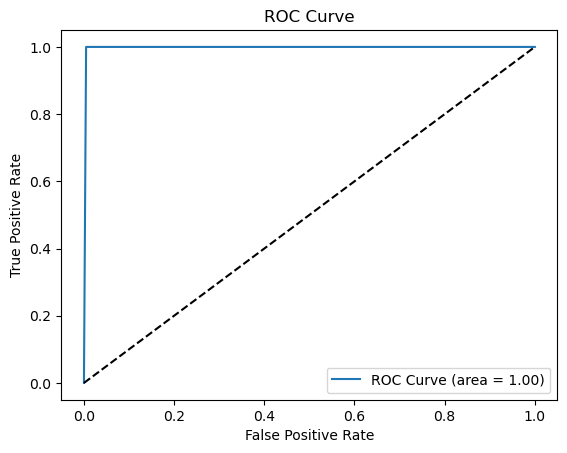

In [34]:
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_scores are defined
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


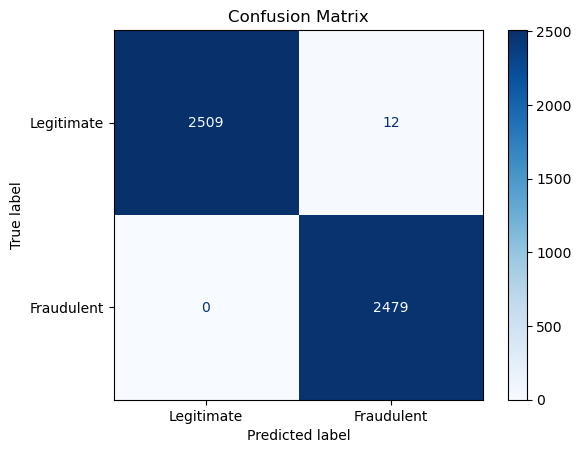

In [35]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and y_pred are defined
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legitimate', 'Fraudulent'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()
